# Implementação do esquema de detecção 1b

Esse jupyter tem como objetivo implementar o esquema 1b de detecção de ataques ativos descrito no artigo "Physical Layer Security for Massive MIMO - Kapetanovic".

No artigo, o autor define:

M -> Quantidade de antenas

L -> Quantidade de sequências piloto enviadas

Y -> Array da sequência piloto com L símbolos

I -> Matriz identidade LxL

N0 -> Potência do ruído na base

R -> Matriz que será construida através dos outros parâmetros. Os dois maiores autovalores dessa matriz podem ser usados para fazer a detecção. Caso a razão entre esses autovalores passe de um determinado limiar, podemos dizer que um ataque está ocorrendo.

a1 -> Maior autovalor de R

a2 -> Segundo maior autovalor de R

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import comm

In [ ]:
# # DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# params = {'figure.figsize': [9, 4], 
#           'axes.labelsize': 10,
#           'axes.titlesize':14, 
#           'font.size': 10,
#           'legend.fontsize': 10, 
#           'xtick.labelsize': 8, 
#           'ytick.labelsize': 8
#          }
# plt.rcParams.update(params)

## Definição de funções

### Definindo uma função para gerar uma sequência de bits

A ideia aqui é só criar um array contendo um bits pra sequência piloto. Como vamos usar modulação QPSK, cada símbolo deve conter 2 bits. A sequência deve ser um array de strings do tipo ["00", "11", "01", ...].

In [2]:
def gerarSequenciaBits(qtdSimbolos):
    
    # INICIANDO O ARRAY
    sequenciaBits = []

    # GERANDO A SEQUENCIA DE BITS COMO UM ARRAY DE STRINGS COMO ["00", "10", ...]
    for i in range(qtdSimbolos):
        sequenciaBits.append(str(np.random.randint(low=0, high=2)) + str(np.random.randint(low=0, high=2)))
        
    return sequenciaBits

Verificando o funcionamento da função criada acima:

In [ ]:
sequenciaBits = gerarSequenciaBits(10)
sequenciaBits

### Definindo função para modular o sinal de uplink

O artigo explica que a sequência piloto enviada deve ser composta de bits aleatórios com modulação n-PSK. Para começar, podemos tentar simular uma modulação BPSK. A função abaixo recebe uma sequência de bits e retorna o sinal modulado em QPSK.

O parâmetro sequenciaBits deve ser um array de strings, como: ["00", "01", "11", ...].

In [3]:
def modularSequenciaBitsQPSK(sequenciaBits, potenciaSinal=1, defasagem=np.pi/4):
    
    # CRIO O ARRAY ONDE VOU GUARDAR OS SIMBOLOS MODULADOS
    simbolosModulados = []
    
    # CRIO OS SIMBOLOS POSSIVEIS VALIDOS APOS A MODULACAO
    simbolosValidos = np.sqrt(potenciaSinal) * np.array([1, 1j, -1, -1j]) * np.exp(1j*defasagem)
    
    # PARA CADA SEQUENCIA DE 2 BITS
    for i, bitsAtuais in enumerate(sequenciaBits):
        
        # SE FOR 00, MANDO O PRIMEIRO SIMBOLO MODULADO
        if bitsAtuais == "00":
            simbolosModulados.append(simbolosValidos[0])
                
        # SE FOR 01, MANDO O SEGUNDO SIMBOLO MODULADO
        elif bitsAtuais == "01":
            simbolosModulados.append(simbolosValidos[1])
            
        # SE FOR 10, MANDO O TERCEIRO SIMBOLO MODULADO
        elif bitsAtuais == "10":
            simbolosModulados.append(simbolosValidos[2])
            
        # SE FOR 11, MANDO O QUARTO SIMBOLO MODULADO
        elif bitsAtuais == "11":
            simbolosModulados.append(simbolosValidos[3])
            
        else:
            print("ALGO DE ERRADO COM A SEQUÊNCIA DE BITS ENVIADA PARA A FUNÇÃO QPSK")
            
    return np.array(simbolosModulados)

Visualizando o funcionamento da função:

In [ ]:
# GERANDO OS SIMBOLOS COM 2 BITS
qtdSimbolos   = 1000
sequenciaBits = gerarSequenciaBits(qtdSimbolos)
    
# MODULANDO A SEQUENCIA DE BITS COM A FUNCAO CRIADA ACIMA
simbolosModulados = modularSequenciaBitsQPSK(sequenciaBits)

# PRINTANDO 
plt.scatter(simbolosModulados.real, simbolosModulados.imag)
plt.title('Constelação QPSK')
plt.xlabel('Real')
plt.ylabel('Imaginário')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

### Definindo função para simular difrações e reflexões no canal

Para facilitar algumas comparações lá na frente, vou deixar possível enviar o fatorCanal como None, dessa forma a função não faz nada.

In [4]:
def simularCanal(simbolosModulados, fatorCanal=1):
    if fatorCanal == None:
        return simbolosModulados
    else:    
        h = np.sqrt(0.5) * (np.random.normal(0, 1, fatorCanal) + 1j*np.random.normal(0, 1, fatorCanal))
        return scipy.signal.lfilter(h, 1, simbolosModulados)

Verificando o funcionamento da função:

In [ ]:
# SIMULANDO O CANAL
simbolosModuladosCanal = simularCanal(simbolosModulados, fatorCanal=1)

# PRINTANDO 
plt.scatter(simbolosModuladosCanal.real, simbolosModuladosCanal.imag)
plt.title('Constelação QPSK')
plt.xlabel('Real')
plt.ylabel('Imaginário')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

### Definindo função para adicionar ruído branco gaussiano na sequência piloto

Depois de criar uma sequência piloto em bits, vamos modular, simular o canal, e, por fim, adicionar um pouco de ruído branco.

In [5]:
def adicionarRuidoBrancoGaussiano(simbolosModuladosCanal, SNR=20, potenciaSinal=1):
    
    potenciaRuido = potenciaSinal/(10**(SNR/10))
    ruido = np.sqrt(potenciaRuido/2) * (np.random.normal(0 , 1, simbolosModuladosCanal.shape) + 1j*np.random.normal(0 , 1, simbolosModuladosCanal.shape))
    
    return simbolosModuladosCanal + ruido

In [ ]:
# ADICIONANDO RUIDO
simbolosModuladosCanalRuidosos = adicionarRuidoBrancoGaussiano(simbolosModuladosCanal, SNR=20)

# PRINTANDO 
plt.scatter(simbolosModuladosCanalRuidosos.real, simbolosModuladosCanalRuidosos.imag)
plt.title('Constelação QPSK')
plt.xlabel('Real')
plt.ylabel('Imaginário')
plt.show()

##### GERANDO OS SIMBOLOS DE 2 BITS
sequenciaBits = gerarSequenciaBits(L)

##### MODULANDO A SEQUENCIA DE BITS
simbolosModulados = modularSequenciaBitsQPSK(sequenciaBits, potenciaSinal)

##### SIMULANDO O CANAL
simbolosModuladosCanal = simularCanal(simbolosModulados, fatorCanal)

##### ADICIONANDO RUIDO
simbolosModuladosCanalRuidosos = adicionarRuidoBrancoGaussiano(simbolosModuladosCanal, SNR, potenciaSinal)

### Definindo função para construir a matriz R e retornar a razão entre seus dois maiores autovalores

In [6]:
def razaoMatrizR(Y, L, M=128, SNR=20, potenciaSinal=1, verbose=False):
    
    # OBTENDO A POTENCIA DO RUIDO N0
    N0 = potenciaSinal/(10**(SNR/10))
    
    # CRIANDO A MATRIZ IDENTIDADE E FAZENDO A OPERACAO HERMITIANA EM Y
    I  = np.identity(L)
    YH = np.conjugate(Y).T
    
    # CONSTRUINDO A MATRIZ R
    R = np.matmul(Y,YH)/M - N0 * I
    
    # DOIS MAIORES AUTOVALORES
    autovalores = np.sort(np.linalg.eigvals(R))
    a1 = autovalores[-1]
    a2 = autovalores[-2]
    
    if verbose:
        print("R:", np.matrix(R))
        print("\nAutovalores:", autovalores)
        print("\nMaior autovalor:", a1)
        print("\nSegundo maior autovalor:", a2)
        print("\nRazão:", (a1/a2).real)
    
    # RETORNO A RAZAO
    return (a1/a2).real

Verificando o funcionamento da função:

In [ ]:
# SIMULANDO TODA A PROPAGACAO DA SEQUENCIA PILOTO
L   = 5
M   = 128
SNR = 50

# GERANDO OS SIMBOLOS, MODULANDO, SIMULANDO O CANAL E ADD RUIDO
sequenciaBits = gerarSequenciaBits(L)
Y = modularSequenciaBitsQPSK(sequenciaBits)
Y = simularCanal(Y)
Y = adicionarRuidoBrancoGaussiano(Y, SNR)

# MANDANDO OS BITS MODULADOS PARA A CONSTRUCAO DA MATRIZ PARA SABER A RAZAO ENTRE
# OS DOIS MAIORES AUTOVALORES
razao = razaoMatrizR(Y, L, M, SNR, verbose=True)

## Testes iniciais

Para fazer um teste básico, vamos estabelecer uma estação base com 128 antenas (M=128), e 10 símbolos na sequência piloto (L=10). Para facilitar, vamos diminuir bastante o ruído (N0 pequeno -> SNR alta).

No primeiro momento, vou fazer só o usuário legítimo enviar a sequência piloto. Em seguida, vamos ver como fica o sistema quando entra um espião. O usuário e o espião vão enviar com a mesma potência e a mesma sequência piloto. A única diferença é o canal e o ruído.

Vou rodar o teste repetibilidade vezes.

In [7]:
# PARAMETROS INCICIAIS
L          = 10
M          = 128
SNR        = 100
fatorCanal = 1 # 1 ou none

# REPETIBILIDADE DO EXPERIMENTO
repetibilidade = 100

# VAMOS ARMAZENAR QUANTAS VEZES A RAZAO COM ESPIAO FOR MAIOR (NAO DESEJADO)
qtdErros = 0
    
# REPRODUZINDO O EXPERIMENTO
for i in range(repetibilidade):

    print("Experimento:", i+1)
    
    # GERANDO A SEQUENCIA PILOTO E MODULANDO ELA
    sequenciaPilotoBits     = gerarSequenciaBits(L)
    sequenciaPilotoModulada = modularSequenciaBitsQPSK(sequenciaPilotoBits)
    
    # USUARIO LEGITIMO (UL) ---------------------------------------------
    # canal + ruido -> razaoAutovalores
    Y_UL = simularCanal(sequenciaPilotoModulada, fatorCanal)
    Y_UL = adicionarRuidoBrancoGaussiano(Y_UL, SNR)
    razaoSemEspiao = razaoMatrizR(Y_UL, L, M, SNR)

    # ESPIAO (ED) ---------------------------------------------
    # canal + ruido -> razaoAutovalores
    Y_ED = simularCanal(sequenciaPilotoModulada, fatorCanal)
    Y_ED = adicionarRuidoBrancoGaussiano(Y_ED, SNR)
    razaoComEspiao = razaoMatrizR(Y_ED+Y_UL, L, M, SNR)  

    # OBSERVANDO AS RAZOES (A DO ESPIAO DEVE SER MENOR)
    print("Razão sem espião:        ", razaoSemEspiao)
    print("Razão com espião:        ", razaoComEspiao)
    print("Razão sem espião é maior:", razaoSemEspiao>razaoComEspiao)
    print("Diferença total:         ", razaoSemEspiao - razaoComEspiao)
    print("Diferença proporcional:  ", razaoComEspiao/razaoSemEspiao, "\n")
    if razaoSemEspiao<razaoComEspiao:
        qtdErros += 1
        
print("Erros:", qtdErros)

Experimento: 1
Razão sem espião:         -4822186816.80928
Razão com espião:         -5065336422.432395
Razão sem espião é maior: True
Diferença total:          243149605.6231146
Diferença proporcional:   1.050423099489953 

Experimento: 2
Razão sem espião:         -8167800715.964774
Razão com espião:         -78151875375.20995
Razão sem espião é maior: True
Diferença total:          69984074659.24518
Diferença proporcional:   9.56828870989156 

Experimento: 3
Razão sem espião:         -3213920204.180013
Razão com espião:         -14145193789.733866
Razão sem espião é maior: True
Diferença total:          10931273585.553852
Diferença proporcional:   4.401227439105886 

Experimento: 4
Razão sem espião:         -3464579960.1270947
Razão com espião:         -8814121803.523705
Razão sem espião é maior: True
Diferença total:          5349541843.39661
Diferença proporcional:   2.5440664972270888 

Experimento: 5
Razão sem espião:         -2995536198.2358594
Razão com espião:         -4055258

Razão sem espião:         -3565948621.4024105
Razão com espião:         -9503222620.36337
Razão sem espião é maior: True
Diferença total:          5937273998.96096
Diferença proporcional:   2.6649914593065445 

Experimento: 73
Razão sem espião:         -9553499009.41307
Razão com espião:         -45131136567.0347
Razão sem espião é maior: True
Diferença total:          35577637557.62163
Diferença proporcional:   4.724042628001212 

Experimento: 74
Razão sem espião:         -19236432546.46354
Razão com espião:         -5449819410.312418
Razão sem espião é maior: False
Diferença total:          -13786613136.151121
Diferença proporcional:   0.28330717752103796 

Experimento: 75
Razão sem espião:         -12542946431.006506
Razão com espião:         -8336847718.228874
Razão sem espião é maior: False
Diferença total:          -4206098712.7776318
Diferença proporcional:   0.6646642209696407 

Experimento: 76
Razão sem espião:         -516914923.92204
Razão com espião:         -9528818167.693

## Comparando quantidade de símbolos enviados na sequência piloto

Vou fazer o teste comparando diferente valores de L. O teste será o de sequências piloto diferentes para o usuário legítimo e para o espião.

In [14]:
# PARAMETROS INICIAIS
M                   = 128
SNR                 = 100
fatorCanal          = None # 1 ou none
repetibilidadeCadaL = 30

# RANGE DE Ls PARA SEREM TESTADOS
rangeL = np.arange(2,100)

# CRIANDO OS ARRAYS QUE ARMAZENARAO OS RESULTADOS DE CADA VALOR DE L
arrayMediaDaDiferencaProporcionalCadaL  = []
arrayDesvioDaDiferencaProporcionalCadaL = []
arrayQtdErrosCadaL                      = []

# PARA ALGUNS VALORES DE L DIFERENTES...
for LAtual in rangeL:
    
    # ARRAY PARA GUARDAR AS DIFERENCAS PROPORCIONAIS DO L ATUAL
    diferencasProporcionaisLAtual = []
    
    # ERROS DO L ATUAL
    errosLAtual = 0
    
    # VAMOS FAZER VARIAS VEZES PRA GARANTIR REPETIBILIDADE
    for i in range(repetibilidadeCadaL):
        
        # GERANDO A SEQUENCIA PILOTO E MODULANDO ELA
        sequenciaPilotoBits     = gerarSequenciaBits(LAtual)
        sequenciaPilotoModulada = modularSequenciaBitsQPSK(sequenciaPilotoBits)

        # USUARIO LEGITIMO (UL) ---------------------------------------------
        # canal + ruido -> razaoAutovalores
        Y_UL = simularCanal(sequenciaPilotoModulada, fatorCanal)
        Y_UL = adicionarRuidoBrancoGaussiano(Y_UL, SNR)
        razaoSemEspiao = razaoMatrizR(Y_UL, LAtual, M, SNR)

        # ESPIAO (ED) ---------------------------------------------
        # canal + ruido -> razaoAutovalores
        Y_ED = simularCanal(sequenciaPilotoModulada, fatorCanal)
        Y_ED = adicionarRuidoBrancoGaussiano(Y_ED, SNR)
        razaoComEspiao = razaoMatrizR(Y_ED+Y_UL, LAtual, M, SNR) 

        # ARMAZENANDO A RAZAO DA REPETIBILIDADE ATUAL E VENDO SE DEU ERRO
        diferencasProporcionaisLAtual.append(razaoComEspiao/razaoSemEspiao)
        if razaoSemEspiao<razaoComEspiao:
            errosLAtual += 1
            
    print("L="+str(len(sequenciaPilotoBits)), end=" ")
            
    # AGORA QUE JA REPETIMOS O EXPERIMENTO VARIAS VEZES PARA O L ATUAL, 
    # VAMOS ARMAZENAR O RESULTADO DO L ATUAL
    arrayMediaDaDiferencaProporcionalCadaL.append(np.mean(diferencasProporcionaisLAtual))
    arrayDesvioDaDiferencaProporcionalCadaL.append(np.std(diferencasProporcionaisLAtual))
    arrayQtdErrosCadaL.append(errosLAtual)

L=2 L=3 L=4 L=5 L=6 L=7 L=8 L=9 L=10 L=11 L=12 L=13 L=14 L=15 L=16 L=17 L=18 L=19 L=20 L=21 L=22 L=23 L=24 L=25 L=26 L=27 L=28 L=29 L=30 L=31 L=32 L=33 L=34 L=35 L=36 L=37 L=38 L=39 L=40 L=41 L=42 L=43 L=44 L=45 L=46 L=47 L=48 L=49 L=50 L=51 L=52 L=53 L=54 L=55 L=56 L=57 L=58 L=59 L=60 L=61 L=62 L=63 L=64 L=65 L=66 L=67 L=68 L=69 L=70 L=71 L=72 L=73 L=74 L=75 L=76 L=77 L=78 L=79 L=80 L=81 L=82 L=83 L=84 L=85 L=86 L=87 L=88 L=89 L=90 L=91 L=92 L=93 L=94 L=95 L=96 L=97 L=98 L=99 

Text(0, 0.5, 'Diferença proporcional entre as razões \n(razaoComEspiao/razaoSemEspiao)')

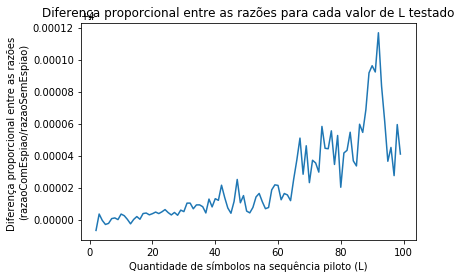

In [15]:
plt.plot(rangeL, arrayMediaDaDiferencaProporcionalCadaL)
plt.title("Diferença proporcional entre as razões para cada valor de L testado")
plt.xlabel("Quantidade de símbolos na sequência piloto (L)")
plt.ylabel("Diferença proporcional entre as razões \n(razaoComEspiao/razaoSemEspiao)")